# Data Generation Example

In [1]:
import sys
import numpy as np
sys.path.append("../")

from data_loader import CityScapesNumpy, plot_detections

# ...

  0%|                                                                                          | 0/599 [00:00<?, ?it/s]

Loading data into array...


100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:08<00:00, 17.51it/s]


Size of data:  13114936848


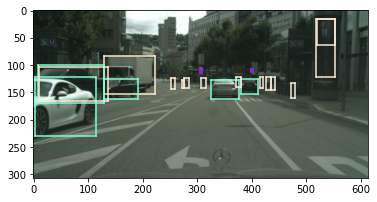

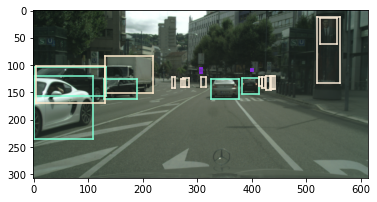

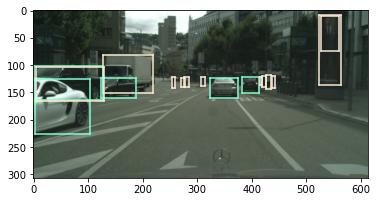

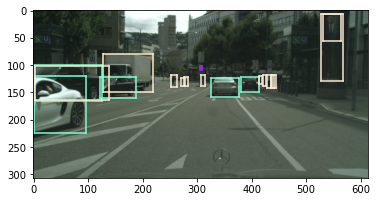

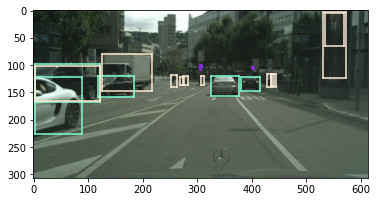

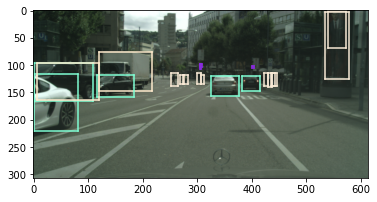

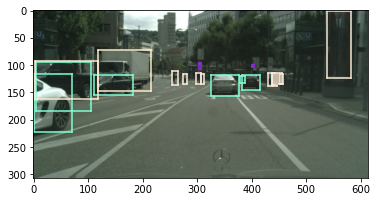

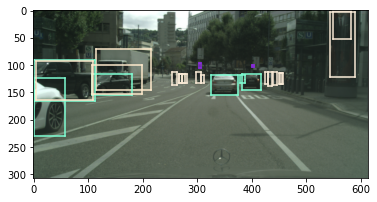

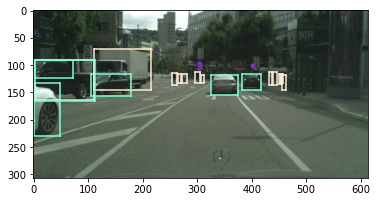

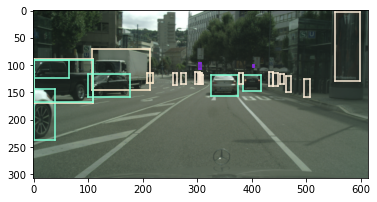

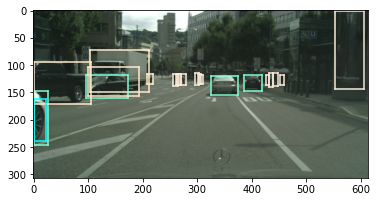

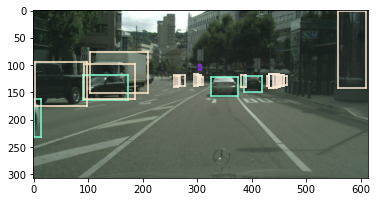

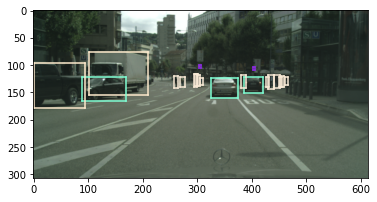

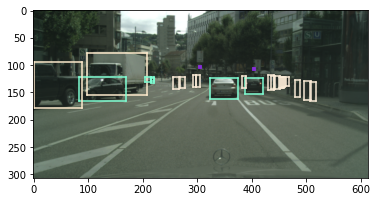

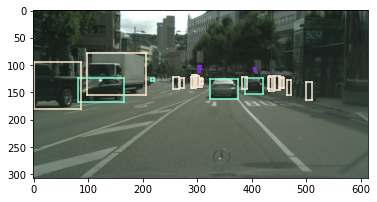

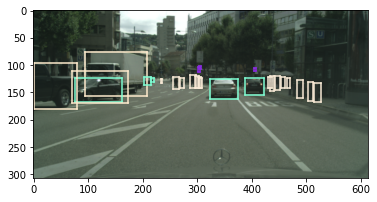

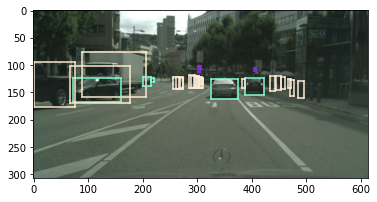

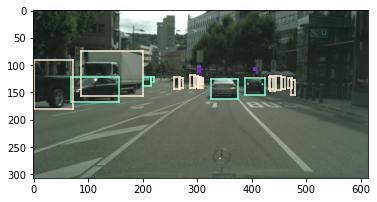

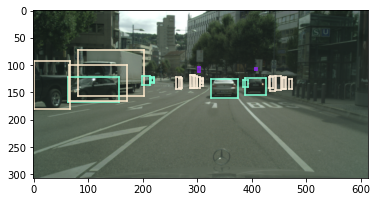

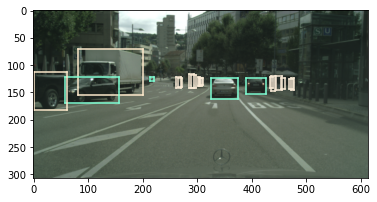

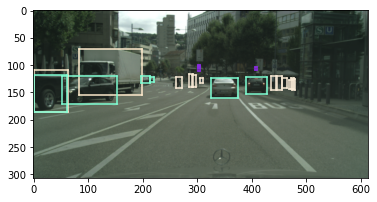

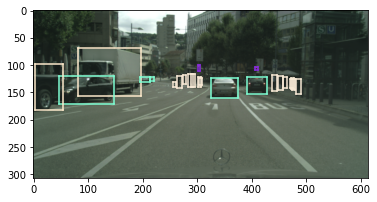

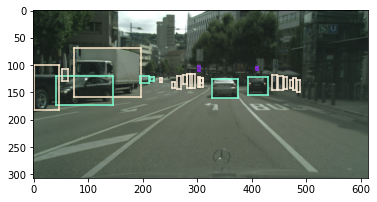

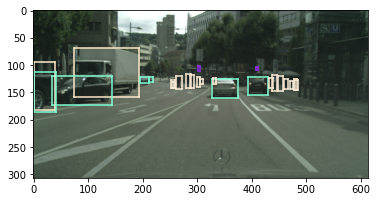

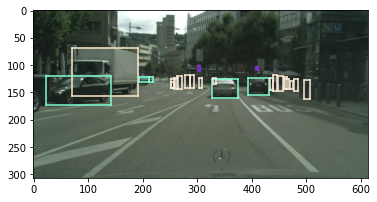

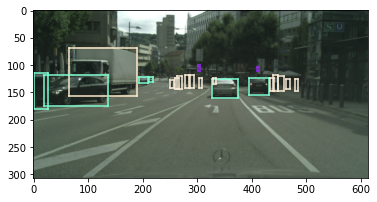

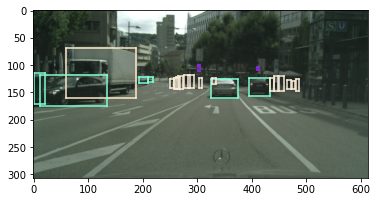

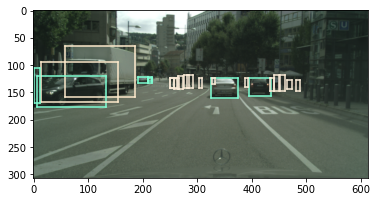

KeyboardInterrupt: 

In [2]:
data_set = CityScapesNumpy()

for i in range(len(data_set)):
    img, bx, lbl, scrs = data_set.get_idx(i)
    plot_detections(img, bx, lbl, scrs, categories=[1, 2, 3, 4, 5, 6, 7, 8, 8, 10])